In [2]:
from qiskit.circuit.quantumregister import QuantumRegister
from qiskit.dagcircuit.dagcircuit import DAGCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.tools.visualization import dag_drawer
import supremacy_generator as suprem_gen
from qiskit.visualization import plot_state_city
import numpy as np
import functools
import timeit
from datetime import timedelta
import supremacy_generator as suprem_gen
import matplotlib.pyplot as plt
from matplotlib import cm
import auto_cut_help_fun as cut_finder

# circ = suprem_gen.circuit_generator(circuit_dimension=[2,3,8])
# pareto_K_d = cut_finder.find_pareto_solutions(circ)
# [print(x, pareto_K_d[x]) for x in pareto_K_d]
graph = cut_finder.Graph([['a','c','e'], ['b','d','e'], ['c','a','f','g'], ['d','b','f','g'], ['e','a','b'], ['f','c','d'],['g','c','d']])
g, grouping, cut_edges = cut_finder.contract(graph)
K = g.edge_count
d = cut_finder.cluster_character(grouping)
print(cut_edges)
print(grouping)
print(K)


contracting ('c', 'g')
contracting ('a', 'e')
contracting ('b', 'e')
contracting ('d', 'g')
contracting ('b', 'd')
original edge ('a', 'c')
is not contracted in [('c', 'g'), ('a', 'e'), ('b', 'e'), ('d', 'g'), ('b', 'd')]

original edge ('c', 'f')
is not contracted in [('c', 'g'), ('a', 'e'), ('b', 'e'), ('d', 'g'), ('b', 'd')]

original edge ('d', 'f')
is not contracted in [('c', 'g'), ('a', 'e'), ('b', 'e'), ('d', 'g'), ('b', 'd')]

[('a', 'c'), ('c', 'f'), ('d', 'f')]
['a e', 'b c g d f']
2


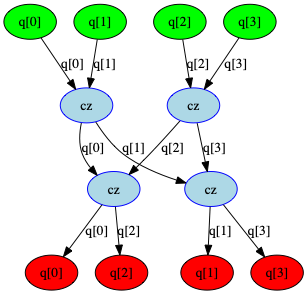

In [18]:
dag_drawer(circuit_to_dag(cut_finder.circ_stripping(circ)))

In [8]:
graph = cut_finder.Graph([['a','b','c','d'], ['b','a','e','f','g'], ['c','a'], ['d','a'], ['e','b'], ['f','b'], ['g','b']])
cut_finder.contract(graph)

(<auto_cut_help_fun.Graph at 0x12689da20>, ['b e g f', 'a c d'], [('a', 'b')])

In [3]:
graph = cut_finder.Graph([['a','b','b','b'], ['b','a','a','a']])
print(graph.verts)
print(graph.edges)
graph.merge_vertices(0)
print('*'*50)
print(graph.verts)
print(graph.edges)

{'a': Counter({'b': 3}), 'b': Counter({'a': 3})}
[('a', 'b'), ('a', 'b'), ('a', 'b')]
removing edge  ('a', 'b') a b
FINISHED edges: []
FINISHED verts: {'a': Counter()}
**************************************************
{'a': Counter()}
[]
